# Principal component analysis for multi-spectral data

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction.
It can be used to explore patterns in high-dimensional data and assist unsupervised learning.

Principal components are a series of linear combinations of the original variables, among which the first principal component accounts for the greatest variance within a dataset.
Each subsequent principal component accounts for the next greatest possible variance and is uncorrelated with the previously defined components.

This technique is useful for understanding Sentinel-2 data as images are captured in 12 spectral bands but only 3 variables can be visualized in a RGB composite.
PCA can also be applied to timeseries data to investigate temporal evolution patterns for different land cover types.

## Description

This notebook demonstrates a principal component analysis for Sentinel-2 multi-spectal data. 
Following steps are covered:

1. Loading Sentinel-2 multi-spectral data.
2. Applying PCA to transform and visualize data.
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

from sklearn.decomposition import PCA
import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten

### Connect to the datacube

Connect to the datacube so we can access DEAfrica data.

In [2]:
dc = datacube.Datacube(app='pca')

### Analysis parameters

This section defines the analysis parameters, including 

* center lat/lon and analysis window size for the area of interest
* time period to be investigated
* projection and resolution for loading data
* acceptable range of cloud cover percentage for input Sentinel-2 granule (`min_gooddata`)
* spectral bands to be explored

The default location is Betsiboka Estuary, Madagascar.

To limit overall memory usage, if a larger analysis window or higher resolution is desired, the time period should be reduced accordingly.

In [3]:
# Create a query object
lat, lon = -15.92, 46.35
buffer = 0.1 

query = {
    'time': ('2020-01', '2020-03'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:6933',
    'resolution':(-20,20),
}

# use all non-overlapping 10m and 20m bands
bands = ['blue', 'green', 'red', 'red_edge_1', 'red_edge_2',
         'red_edge_3', 'nir_narrow', 'swir_1', 'swir_2']

## Loading Sentinel-2 multi-spectral data

Only high probablity cloud is excluded in this example, but this can be modified for a different area.


In [4]:
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              measurements=bands,
              min_gooddata=0.98,
              group_by='solar_day',
              **query)


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 4 out of 18 time steps with at least 98.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


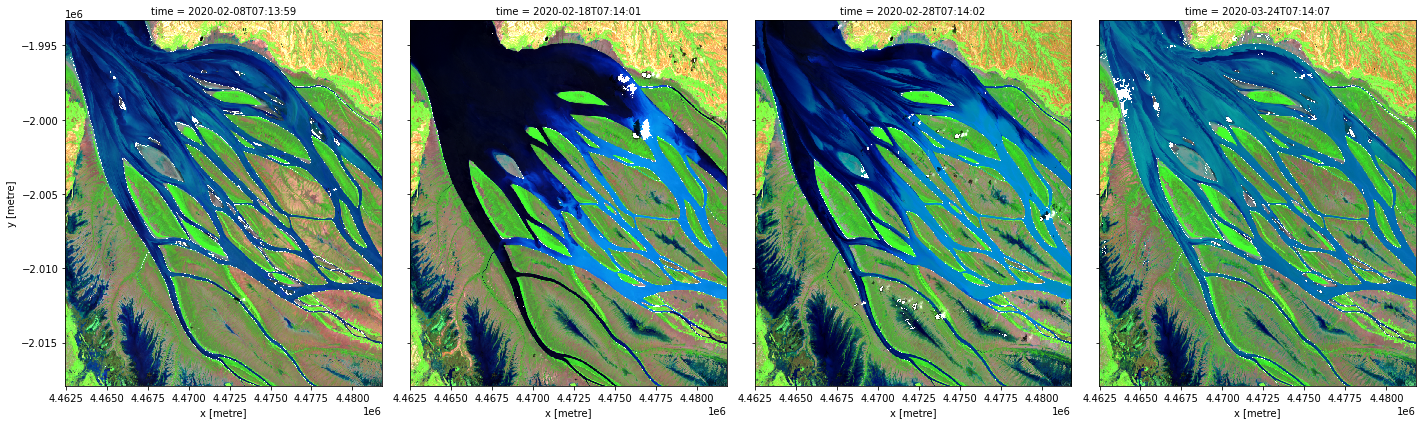

In [5]:
# visualize data using selected input spectral bands
rgb(ds, bands=['swir_1','nir_narrow','red_edge_1'], index=list(range(len(ds.time))), col_wrap=4)

## Applying PCA to transform and visualize data

To perform a PCA, data is first transformed into a numpy array that can be used by sklearn.

In [117]:
import xarray as xr
import numpy as np
from datacube.utils.geometry import assign_crs

def raster_stack(input_xr):
    """
    Reshape a DataArray or Dataset with spatial (and optionally
    temporal) structure into an np.array with the spatial and temporal
    dimensions flattened into one dimension.
    This flattening procedure enables DataArrays and Datasets to be used
    to train and predict with sklearn models.
    Last modified: November 2021
    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.
    Returns
    ----------
    input_np : numpy.array
        A numpy array corresponding to input_xr.data (or
        input_xr.to_array().data), with dimensions 'x','y' and 'time'
        flattened into a single dimension, which is the first axis of
        the returned array. input_np contains no NaNs.
    """
    
    # Cast input DataArrays to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()
    
    # Work around for input_xr Dataset with geographic coordinate reference system.
    if input_xr.geobox.crs.geographic:
        input_xr = input_xr.rename({"longitude": "x", "latitude": "y"})
       
    # Get the data type for the input_xr Dataset data values.
    data_type = input_xr.to_array().data.dtype

    # Get the number of bands in the input_xr Dataset.
    bands_list = list(input_xr.data_vars)
    nbands = len(bands_list)
   
    # Get the dimensions x , y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]
    
    # Get the dimension time of the input_xr Dataset.
    # Create an empty numpy array, input_np, in which each column will hold a
    # flattened band/measurement from the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        input_np = np.empty((height * width * time, nbands), dtype=data_type)
    else:
        input_np = np.empty((height * width, nbands), dtype=data_type)

    # Loop through each band in the input_xr Dataset and add it
    # to the numpy array model_input.
    for i, band in enumerate(bands_list):
        band_array = np.array(input_xr[band])
        # Impute the bands because sklearn cannot accept Nans as input.
        median_value = np.nanmedian(band_array)
        band_array = np.nan_to_num(band_array, nan=median_value, posinf=median_value, neginf=median_value)
        input_np[:, i - 1] = band_array.flatten()

    return input_np


def raster_unstack(output_np, input_xr):
    """
    Reshape a numpy array with no 'missing' elements (NaNs) and
    'flattened' spatiotemporal structure into a DataArray matching the
    spatiotemporal structure of the DataArray
    This enables an sklearn model's prediction to be remapped to the
    correct pixels in the input DataArray or Dataset.
    Last modified: November 2021
    Parameters
    ----------
    output_np : numpy.array
        The first dimension's length should correspond to the number of
        valid (non-NaN) pixels in input_xr.
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.
    Returns
    ----------
    output_xr : xarray.Dataset
        An xarray.Dataset with the same dimensions 'x', 'y' and 'time'
        as input_xr, and the same valid (non-NaN) pixels. These pixels
        are set to match the data in output_np.
    """
    
    # The  expected output of a sklearn model prediction should just be 
    # a 1 dimensional numpy array, output_np, with the size/columns matching 
    # the height * width * time  for the dimensions of the input_xr DataArray/Dataset.

    # Cast the input DataArray to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()
    
    # Work around for input_xr Dataset with geographic coordinate reference system.
    if input_xr.geobox.crs.geographic:
        input_xr = input_xr.rename({"longitude": "x", "latitude": "y"})
        
    # Get the dimensions x , y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]
        
    # Get the dimension time of the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((-1, time, height, width))
        # Create an empty xarray Data Array using the input_xr dimensions and attributes.
        output_xr = xr.Dataset(
            coords=dict(
                time=(["time"], input_xr.coords["time"].values),
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,),
            attrs=input_xr.attrs)
        # Add the output_np data to the empty output_xr Dataset. 
        for band in range(output_np.shape[0]):
            label='band_%d'%(band)
            output_xr[label] = (["time", "y", "x"], output_np[band])
    
    else:
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((-1, height, width))
        # Create an empty xarray Data Array using the input_xr dimensions and attributes.
        output_xr = xr.DataArray(
            output_np,
            coords=dict(
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,
            ),
            attrs=input_xr.attrs,
        )
        # Add the output_np data to the empty output_xr Dataset. 
        for band in range(output_np.shape[0]):
            label='band_%d'%(band)
            output_xr[label] = (["y", "x"], output_np[band])
    
   # Assign the input_xr crs to the output_xr Dataset.
    output_xr = assign_crs(output_xr, input_xr.geobox.crs)
    
    # Work around for input_xr Dataset with geographic coordinate reference system.
    if input_xr.geobox.crs.geographic:
        output_xr = output_xr.rename({"x": "longitude", "y": "latitude"})

    return output_xr

In [107]:
X = sklearn_flatten(ds)
print(X.shape)
print(X)

(4699223, 9)
[[ 406.  838. 1090. ...  250.  114.   98.]
 [ 378.  749.  466. ...   56.   23.   13.]
 [ 348.  880. 1854. ...  734.   28.   10.]
 ...
 [ 195.  476.  566. ... 1087.  298.  126.]
 [ 218.  484.  484. ...  884.  295.  154.]
 [ 352.  921.  563. ... 2513.  946.  454.]]


In [108]:
X1 = raster_stack(ds)
print(X1.shape)
print(X1)

(4748856, 9)
[[ 838. 1090. 1054. ...  114.   98.  406.]
 [ 945. 1262. 1148. ...  115.  104.  447.]
 [ 917. 1302. 1164. ...  114.   96.  431.]
 ...
 [1140.  597. 1721. ...  851.  426.  481.]
 [ 990.  596. 1549. ... 1046.  519.  379.]
 [ 921.  563. 1587. ...  946.  454.  352.]]


In [133]:
# sklearn expects the data in the shape (n_samples, n_features) where n_features is the number of bands and 
# n_samples is the total number of pixels in each band.

arr = ds.to_array().values
arr.shape

(9, 4, 1229, 966)

In [135]:
flattened_npa = np.array([arr[i].flatten() for i in range(arr.shape[0])])
flattened_npa.shape

(9, 4748856)

In [139]:
input_xr = ds
# cast input Datasets to DataArray
if isinstance(input_xr, xr.Dataset):
    input_xr = input_xr.to_array()

# generate the same mask we used to create the input to the sklearn model
if "time" in input_xr.dims:
    stacked = input_xr.stack(z=["x", "y", "time"])
else:
    stacked = input_xr.stack(z=["x", "y"])
    
stacked.data

array([[ 406.,  378.,  348., ...,  195.,  218.,  352.],
       [ 838.,  749.,  880., ...,  476.,  484.,  921.],
       [1090.,  466., 1854., ...,  566.,  484.,  563.],
       ...,
       [ 250.,   56.,  734., ..., 1087.,  884., 2513.],
       [ 114.,   23.,   28., ...,  298.,  295.,  946.],
       [  98.,   13.,   10., ...,  126.,  154.,  454.]], dtype=float32)

In [142]:
stacked.data.shape

(9, 4748856)

In [146]:
flattened_npa.transpose().shape

(4748856, 9)

A PCA model is generated with 3 principal components and fitted on the data.

In [109]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [110]:
pca1 = PCA(n_components=3)
pca1.fit(X1)

PCA(n_components=3)

We can investigate how much variance is accounted for in each principal component.
In the default example, the first principal component accounts for a much high variance than the next two.

This step can help determine whether more principal components are needed.

In [111]:
print("Relative variance in principal components:", pca.explained_variance_ratio_)

Relative variance in principal components: [0.63061713 0.21630585 0.14659822]


In [112]:
print("Relative variance in principal components:", pca1.explained_variance_ratio_)

Relative variance in principal components: [0.63203695 0.21677424 0.14703856]


The input data can now be transformed into this new reference space and rearranged into a xarray dataset compatible with input data.

In [113]:
predict = pca.transform(X)
predict

array([[-2865.5115 ,  -930.75073,   211.23395],
       [-3187.3018 , -1876.9385 ,  -160.94366],
       [-2143.2097 ,   627.5333 ,   184.85406],
       ...,
       [-1618.9114 ,  -833.0957 ,  -590.3511 ],
       [-1752.8395 ,  -970.9601 ,  -544.41345],
       [  691.65607,   273.51758,  -878.3198 ]], dtype=float32)

In [114]:
predict1 = pca1.transform(X1)
predict1

array([[-2861.8245 ,  -934.41345,   218.90202],
       [-2832.5225 ,  -737.46014,   312.8157 ],
       [-2847.8958 ,  -707.2177 ,   324.03815],
       ...,
       [  490.34528,   381.0655 ,  -739.50183],
       [  585.9226 ,   149.61404,  -672.75165],
       [  695.4506 ,   269.67377,  -870.65845]], dtype=float32)

In [129]:
predict1.shape

(4748856, 3)

In [131]:
9 * 4 * 1229 * 966

42739704

In [115]:
out = sklearn_unflatten(predict, ds)
out = out.to_dataset(dim=out.dims[0]).transpose('time','y','x')
out

<xarray.Dataset>
Dimensions:  (x: 966, y: 1229, time: 4)
Coordinates:
  * x        (x) float64 4.462e+06 4.463e+06 4.463e+06 ... 4.482e+06 4.482e+06
  * y        (y) float64 -1.993e+06 -1.993e+06 ... -2.018e+06 -2.018e+06
  * time     (time) datetime64[ns] 2020-02-08T07:13:59 ... 2020-03-24T07:14:07
Data variables:
    0        (time, y, x) float64 -2.866e+03 -2.836e+03 ... 582.1 691.7
    1        (time, y, x) float64 -930.8 -733.8 -703.6 ... 384.9 153.4 273.5
    2        (time, y, x) float64 211.2 305.2 316.5 ... -747.0 -680.4 -878.3

In [118]:
out1 = raster_unstack(predict1, ds)
out1

<xarray.Dataset>
Dimensions:      (time: 4, y: 1229, x: 966)
Coordinates:
  * time         (time) datetime64[ns] 2020-02-08T07:13:59 ... 2020-03-24T07:...
  * y            (y) float64 -1.993e+06 -1.993e+06 ... -2.018e+06 -2.018e+06
  * x            (x) float64 4.462e+06 4.463e+06 ... 4.482e+06 4.482e+06
    spatial_ref  int32 6933
Data variables:
    band_0       (time, y, x) float32 -2.862e+03 -934.4 218.9 ... -650.4 -373.0
    band_1       (time, y, x) float32 871.6 -626.0 -388.0 ... -94.53 -361.8
    band_2       (time, y, x) float32 1.606e+03 50.48 169.0 ... 269.7 -870.7
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

### Visualise PCA results

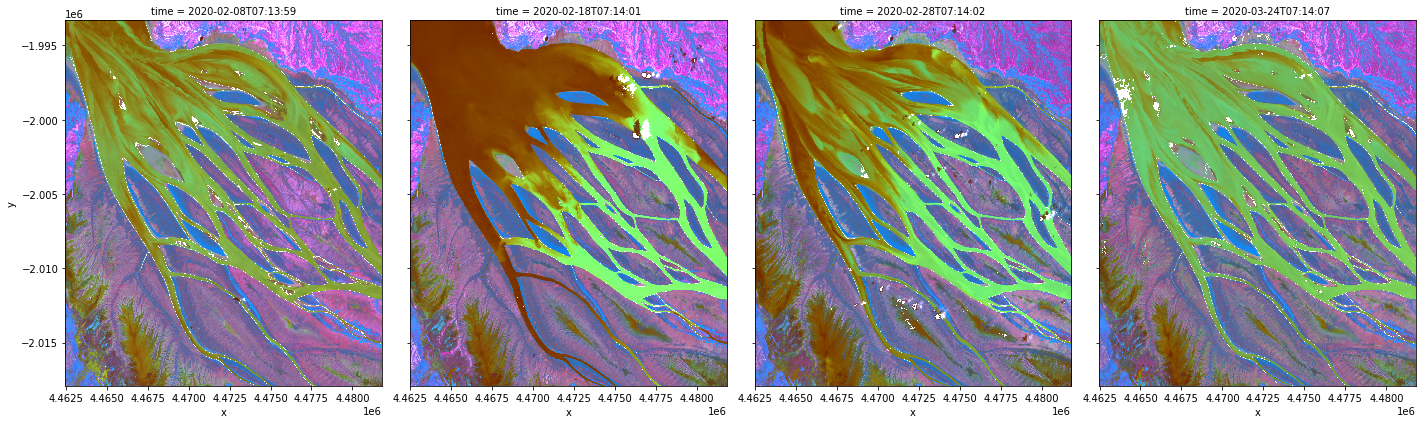

In [120]:
rgb(out, bands=[2,1,0], index=list(range(len(out.time))), col_wrap=4)

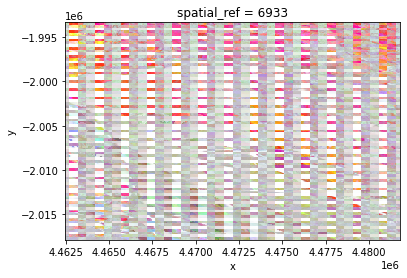

In [128]:
out1.band_0.plot.imshow(cmap="Greys_r", robust=True)

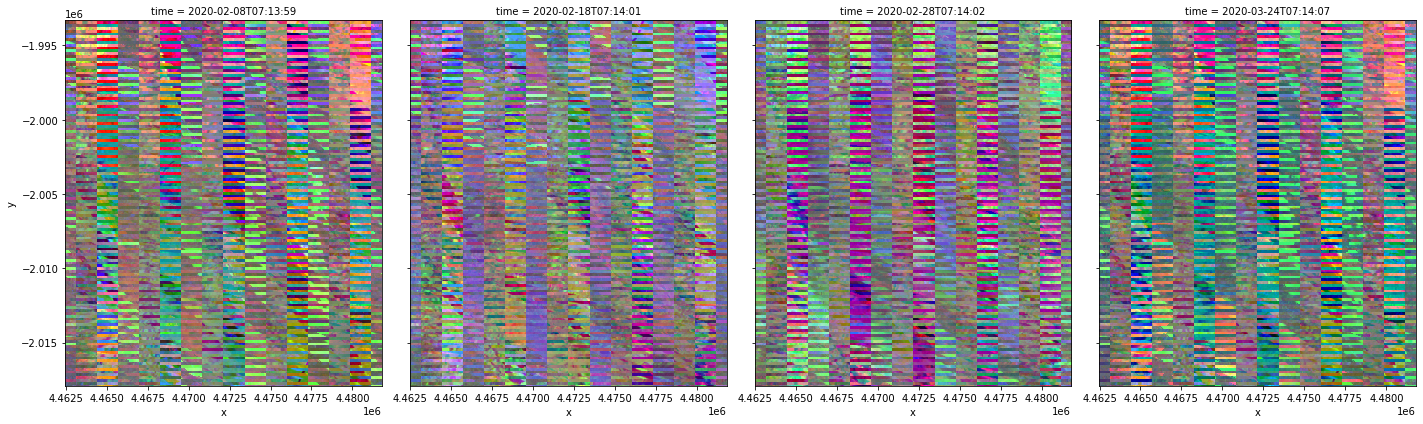

In [122]:
rgb(out1, bands=['band_2','band_1','band_2'], index=list(range(len(out.time))), col_wrap=4)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-12-06'